In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# default_exp apply
pass # xpython fix

# Apply preprocessing to db

> API

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
from ifcimglib import imglmdb, utils, preprocessing, cif2lmdb
import numpy
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
import logging
import lmdb
from pathlib import Path
from tqdm import tqdm
import os

In [ ]:
# export

def preprocess_db(db, preprocessed_output_path):
    logger = logging.getLogger(__name__)
    
    if Path(preprocessed_output_path).exists():
        Path(preprocessed_output_path).unlink()
    
    env = lmdb.open(preprocessed_output_path, lock=False, sync=False, map_size=cif2lmdb.map_size, subdir=False)
    logger.info("Opened lmdb database %s" % preprocessed_output_path)
    
    with env.begin(write=True) as txn:
        txn.put(b'__targets__', pickle.dumps(db.targets))
        txn.put(b'__len__', len(db).to_bytes(db.idx_byte_length, "big"))
        txn.put(b'__names__', " ".join(db.names).encode("utf-8"))
        
        for i in trange(len(db)):
            x, m, _ = db.get_image(i)
            x = x.astype(numpy.float32)
            x = preprocessing.min_max_normalize(x, m, "zero")
            x = preprocessing.crop_and_pad_to_square(x, 70)
            m = preprocessing.crop_and_pad_to_square(m.astype(numpy.uint8), 70).astype(bool)
            
            instance = cif2lmdb.get_instance(x.shape[1:], x.shape[0])
            instance = cif2lmdb.set_instance_data(instance, x.astype(numpy.float16), m)
            
            txn.put(i.to_bytes(db.idx_byte_length, byteorder='big'), pickle.dumps(instance))
            
    env.sync()
    logger.info("Finished pre-pixel-mean preprocessing")
    
    preprocessed_db = imglmdb.imglmdb(preprocessed_output_path)
    per_pixel_mean = preprocessing.compute_per_pixel_mean(preprocessed_db, x.shape)
    
    with env.begin(write=True) as txn:        
        for i in trange(len(db)):
            x, m, _ = preprocessed_db.get_image(i)
            x = x.astype(numpy.float16) - per_pixel_mean
            
            instance = cif2lmdb.get_instance(x.shape[1:], x.shape[0])
            instance = cif2lmdb.set_instance_data(instance, x.astype(numpy.float16), m)
            
            txn.put(i.to_bytes(preprocessed_db.idx_byte_length, byteorder='big'), pickle.dumps(instance), overwrite=True)
            
    env.sync()

In [ ]:
db = imglmdb.imglmdb("/home/maximl/scratch/data/wbc/wbc_2/set1/all stains laser on 60x_1_Focused & Singlets & CD45 pos.lmdb")
preprocess_db(db, "/home/maximl/scratch/data/wbc/wbc_2/set1/CD45_focused_singlets_preprocessed.lmdb")

In [ ]:
db = imglmdb.imglmdb("/home/maximl/scratch/data/wbc/wbc_2/set1/CD45_focused_singlets_preprocessed.lmdb")

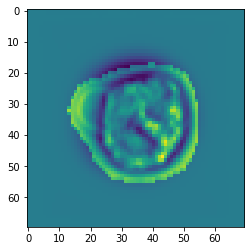

In [ ]:
i = db.get_image(0)[0][0]
i = ((i - i.min()) / (i.max() - i.min())) * numpy.iinfo(numpy.uint16).max
plt.imshow(i.astype(numpy.uint16))

In [ ]:
for db_path in [f for f in Path("/home/maximl/scratch/data/wbc/").rglob("*.lmdb") if "preprocessed" not in str(f)]:
    db = imglmdb.imglmdb(str(db_path))
    preprocess_db(db, os.path.join(*db_path.parts[:-1], "CD45_focused_singlets_preprocessed.lmdb"))

100%|██████████| 29994/29994 [00:11<00:00, 2647.56it/s]
